<a href="https://colab.research.google.com/github/PankajShukla/Stock-Market-Trend-Prediction/blob/main/Production_Trend_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM machine learning algorithm in Production

# Library installation

In [1]:
!pip install Keras

In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import datetime
sns.set_style('whitegrid')

%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib. dates as mandates
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras import callbacks

from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_column", 500)

from google.colab import drive

import h5py

import panel as pn
pn.extension()

# Setting up Drive for pulling data

In [3]:
drive.mount('/content/drive', force_remount=True)
DrivePath = input('Enter Drive Path Location where the file is stored.')

Mounted at /content/drive
Enter Drive Path Location where the file is stored./content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/


In [4]:
# /content/drive/MyDrive/Data Scientist/Interview/Interview offline problem solving/Aditya Birla Group/

# Loading the Dataset

In [5]:
cwdir = os.getcwd()
filename = 'Input_data.csv'
filename = os.path.join(cwdir,DrivePath,filename)

In [6]:
df = pd.read_csv(filename)
df.head(3)

,Date-Time,Open,High,Low,Close,cci_50,Close_supertrend_diff,ATR_EMA_diff,Trend_initial,Trend_final
0,04/01/11 9:55,6150.10,6150.10,6136.00,6136.30,-283.26,-0.01,2.53,1,0
1,04/01/11 10:00,6135.90,6145.75,6134.85,6145.40,-240.60,0.00,2.57,1,0
2,04/01/11 10:05,6145.55,6150.00,6145.20,6148.25,-161.85,0.00,2.24,1,0


# Data Exploration, Data Cleaning and Metrics Derivation

In [7]:
df['timestamp'] = pd.to_datetime(df['Date-Time'], format='%d/%m/%y %H:%M')

df['date'] = df['timestamp'].dt.date

df['dayofweek'] = df['timestamp'].dt.weekday
df['dayofmonth'] = df['timestamp'].dt.day
df['year'] = df['timestamp'].dt.year
df['quarter'] = df['timestamp'].dt.quarter
df['month'] = df['timestamp'].dt.month
df['weekofyear'] = df['timestamp'].dt.isocalendar().week
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute

df['prev_Close'] = df['Close'].shift(1)
df['prev_Close'].fillna(df['Close'], inplace=True)

df['TR1'] = df['High']-df['Low']
df['TR2'] = df['High']-df['prev_Close']
df['TR3'] = df['Low'] -df['prev_Close']

df['TR'] = df[['TR1','TR2','TR3']].max(axis=1)

df['ATR'] = df['Close'].rolling(14, min_periods=1).mean()
df['SMA_50'] = df['Close'].rolling(50, min_periods=1).mean()
df['EMA_50'] = df['Close'].ewm(com=2).mean()

In [8]:
df.drop(columns=['prev_Close', 'TR1', 'TR2', 'TR3'], inplace=True)

In [9]:
df = df[~((df.Trend_initial==1) & (df.Trend_final==0))]
df_2024 = df[df.year==2024]

In [10]:
output_var = pd.DataFrame(df_2024['Trend_final'])
features = ['Close', 'cci_50', 'Close_supertrend_diff', 'ATR_EMA_diff', 'TR']

# Scaling function

In [11]:
def variable_scaling( _df, features, output_var):

  #Scaling
  scaler = MinMaxScaler()
  feature_transform = scaler.fit_transform(_df[features])
  feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=_df.index)
  feature_transform.head()

  return feature_transform

# Classification report generating function

In [12]:
def generate_classification_report(_model, X_test, y_test ):
  testPredict = _model.predict(X_test)
  yPred = testPredict.ravel()

  yPred_ = []
  for v in yPred:
    if v>=0.5:
      yPred_.append(1)
    else:
      yPred_.append(0)

  print(classification_report(yPred_, y_test))
  return yPred_

# Main Block to call all functions

In [13]:

def main(DrivePath, _df):

  filepath1 = os.path.join(DrivePath, 'model')
  modelFileList = []
  for modelFile in os.listdir(filepath1):
      if modelFile.find('h5') > -1:
          modelFileList.append(modelFile)

  modelFileList = sorted(modelFileList)
  modelFile = modelFileList[-1]


  """
  ------------------------------------------------------------
  Load Stored Model
  ------------------------------------------------------------
  """
  LSTM_model = load_model(os.path.join(filepath1, modelFile))

  print(_df.shape)
  X_try_feature_transform = variable_scaling(_df, features, output_var)

  X_try = np.array(X_try_feature_transform).reshape(X_try_feature_transform.shape[0], 1, X_try_feature_transform.shape[1])
  y_try = pd.DataFrame(_df['Trend_final']).values.ravel()
  print(X_try.shape, y_try.shape)

  scores = LSTM_model.evaluate(X_try, y_try, verbose=1)
  print("Accuracy: %.2f%%" % (scores[1]*100))

  y_try_pred = generate_classification_report(LSTM_model, X_try, y_try)
  _df = pd.merge(_df, pd.DataFrame(y_try_pred, columns=['predicted_TrendFinal']), on=_df.index, how='left')
  _df['Close_TrendFinal'] = np.where(_df['Trend_final']==1, _df['Close']*(1-0.0003), np.nan)
  _df['Close_Precicted_TrendFinal'] = np.where(_df['predicted_TrendFinal']==1, _df['Close']*(1+0.0003), np.nan)

  return _df

# Run the script

In [14]:

if __name__ == "__main__":
    # Execute the main function if the script is run directly
    output_data = main(DrivePath, df_2024)

(6138, 24)
(6138, 1, 5) (6138,)
192/192 [==============================] - 1s 2ms/step - loss: 0.5099 - accuracy: 0.8504
Accuracy: 85.04%
192/192 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      4672
           1       0.63      0.89      0.74      1466

    accuracy                           0.85      6138
   macro avg       0.80      0.86      0.82      6138
weighted avg       0.88      0.85      0.86      6138



# View the Stock Graph basis selected date

The below plot shows trend curve for a specific day - '2024-05-29'


*   Close (blue)
*   EMA50 (green)
*   upward trend positions - actual (red)
*   upward trend positions - predicted (purple)


In [15]:
date_picker = pn.widgets.DatePicker(name='Date Picker', value=df_2024['date'].max())
pn.Column(date_picker, height=350)

Column(height=350)
    [0] DatePicker(name='Date Picker', value=datetime.date(2024, ...)

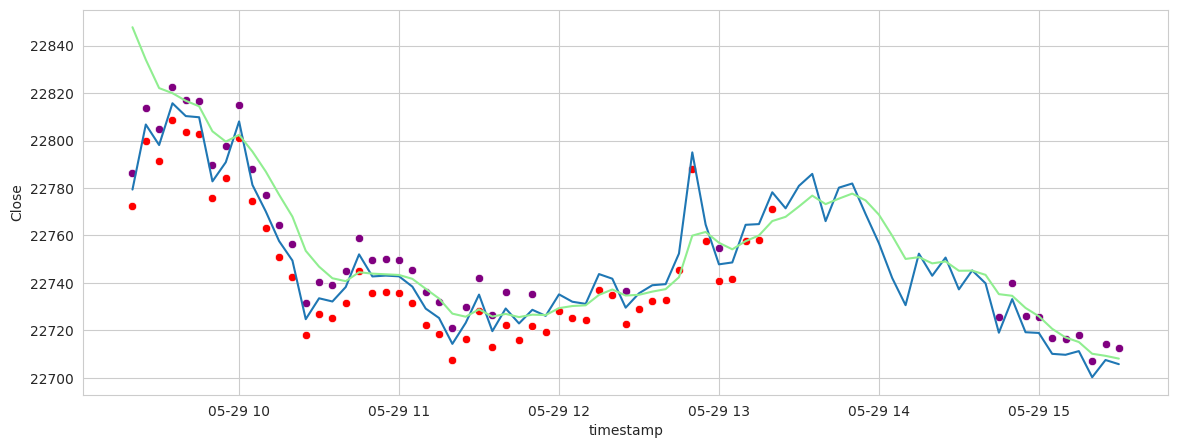

In [16]:
data = output_data[output_data['date'] == date_picker.value]

fig, axes = plt.subplots(1,1, figsize = (14,5))
sns.lineplot(data=data, x='timestamp', y='Close', ax=axes)
sns.lineplot(data=data, x='timestamp', y='EMA_50', ax=axes, color='lightgreen')
sns.scatterplot(data=data, x='timestamp', y='Close_TrendFinal', ax=axes, color='red')
sns.scatterplot(data=data, x='timestamp', y='Close_Precicted_TrendFinal', ax=axes, color='purple')
plt.show()

# Code Ends